# Neural and Evolutionary Leaning Project 

Group members: 

- Iris Moreira - 20240659
- Leonardo Di Caterina - 20240485
- Rafael Borges - 20240497

# Fifth Delivery - NEAT

# First Attempt (Less Speciation)

In [1]:
# Standard library imports
import os
import random

# Third-party imports
import torch.nn as nn

# Slim-GSGP imports
from slim_gsgp.datasets.data_loader import load_pandas_df

In [2]:
os.chdir(os.path.join(os.getcwd(), os.pardir))
from utils.grid_search import gp_nested_cross_validation, fit_model_GridSearch, group_and_median_rmse
from utils.visualization_funcs import *
from utils.NEAT_utils import *
%cd notebooks/

c:\Users\irism\OneDrive - NOVAIMS\Msc-NEL\Neural_Evo_Learn\notebooks


## Load Data

In [3]:
# Reading the desired dataset
df = pd.read_csv("../data/sustavianfeed.csv", sep=';')

# Dropping the first column (index) and renaming the columns
df = df.drop(columns= ['WING TAG', 'EMPTY MUSCULAR STOMACH'])

# Moving crude protein to the end of the dataframe
df = df[[col for col in df.columns if col != 'CRUDE PROTEIN'] + ['CRUDE PROTEIN']]

In [4]:
df

,WEIGHT,HOT CARCASS WEIGHT,CARCASS WEIGHT WITH HEAD AND LEGS,COLD CARCASS WEIGHT,BREAST WEIGHT (2),THIGH WEIGHT (2),SPLEEN,LIVER,HEART,INTESTINE,GLANDULAR STOMACH,ETHER EXTRACT,CRUDE PROTEIN
0,2223.3,1429.6,1725.6,1394.0,214.0,489.4,3.716,38.636,9.305,123.171,13.170,0.38,86.105469
1,2201.9,1450.2,1769.8,1405.4,236.0,538.7,3.494,34.725,10.084,71.800,9.781,1.66,86.143472
2,2159.9,1398.4,1724.9,1461.7,241.8,512.1,4.023,31.932,10.635,61.380,6.217,0.98,86.416898
3,2198.7,1473.9,1800.4,1425.1,227.7,549.9,3.087,32.326,11.927,64.879,8.358,1.10,85.959935
4,2003.2,1291.2,1581.6,1260.1,224.7,473.2,3.723,30.105,9.855,68.562,7.572,6.34,81.693637
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2633.1,1683.2,2034.1,1637.2,213.8,610.9,4.777,45.992,12.796,74.888,7.857,1.07,88.999126
92,2346.2,1547.8,1819.5,1511.2,228.0,528.2,3.673,35.090,11.504,68.455,7.837,1.13,88.507288
93,2648.2,1722.9,2050.0,1669.8,253.1,610.0,5.176,50.505,17.194,81.502,7.332,1.91,90.375587
94,2262.6,1498.5,1813.9,1468.0,212.1,548.4,2.829,30.266,11.129,53.011,5.425,2.21,91.211353


# Nested CV with Grid Search

In [5]:
seed = 42
random.seed(seed)

# Edit the name and log directory based on the model you want to run

#MODEL_NAME = 'GP'
#MODEL_NAME = 'GSGP'
#MODEL_NAME = 'SLIM-GSGP'
#MODEL_NAME = 'NN'
MODEL_NAME = 'NEAT'
DATASET_NAME = MODEL_NAME +'_sustavianfeed'
LOG_DIR = './log/' + MODEL_NAME + '/'

LOG_LEVEL = 2
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

In [6]:
k_outer = 10
k_inner = 5

In [7]:
# Turning df into X and y torch.Tensors
X, y = load_pandas_df(df, X_y=True)

In [8]:
total_instances = X.shape[0]
outer_test_size = total_instances // k_outer
outer_train_size = total_instances - outer_test_size
inner_val_size = outer_train_size // k_inner
inner_train_size = outer_train_size - inner_val_size

print(f'Total Instances:\t{total_instances}\n--')
print(f'Outer Train set:\t{outer_train_size}')
print(f'Test set:\t\t{outer_test_size}\n--')
print(f'Inner Train set:\t{inner_train_size}')
print(f'Validation set:\t\t{inner_val_size}\n')

Total Instances:	96
--
Outer Train set:	87
Test set:		9
--
Inner Train set:	70
Validation set:		17



In [9]:
inner_train_size

70

## NEAT Wrapper

In [10]:
fixed_params = {
    # Core NEAT population & evolution
    'pop_size':100, # Example: Try different population sizes
    
    # Essential for NEATWrapper initialization:
    'config_file_path': 'neat_config.txt', # Path to your NEAT config file
    'generations':100,                  # Number of generations for each NEAT run

    # Problem-specific parameters from NEAT config:
    'num_inputs': 12,
    'num_outputs': 1,
    'fitness_criterion': 'max',
    'fitness_threshold': 0.95,

    # Core NEAT algorithm parameters (usually fixed for a given experiment):
    'feed_forward': True,
    'initial_connection': 'full_direct',
    'reset_on_extinction': False,
    'enabled_default': True,
    'enabled_mutate_rate': 0.01,
    'aggregation_default': 'sum',
    'aggregation_mutate_rate': 0.0,
    #'aggregation_options': 'sum', # Only 'sum' is an option here
    
    'compatibility_disjoint_coefficient': 0.8,
    'compatibility_weight_coefficient': 0.3,

    # Bias mutation parameters (often fixed, but 'bias_mutate_rate' can be dynamic)
    'bias_init_mean': 0.0,
    'bias_init_stdev': 1.0,
    'bias_max_value': 30.0,
    'bias_min_value': -30.0,
    'bias_mutate_power': 0.5,
    'bias_replace_rate': 0.1,

    # Node response parameters (often fixed, but 'response_mutate_rate' can be dynamic)
    'response_init_mean': 0.0,
    'response_init_stdev': 1.0,
    'response_max_value': 30.0,
    'response_min_value': -30.0,
    'response_mutate_power': 1.0,
    'response_replace_rate': 0.0,

    # Weight mutation parameters (often fixed, but 'weight_mutate_rate' can be dynamic)
    'weight_init_mean': 0.0,
    'weight_init_stdev': 1.0,
    'weight_max_value': 30,
    'weight_min_value': -30,
    'weight_mutate_power': 0.5,
    'weight_replace_rate': 0.1,

    # Speciation and Reproduction parameters:
    'species_fitness_func': 'max',
    'max_stagnation': 20,
    'species_elitism': 2,
    'elitism': 2,
    'survival_threshold': 0.2,

    # Placeholder for data and log_level (set dynamically by nested CV function):
    'X_train': None,
    'y_train': None,
    'X_test': None,
    'y_test': None,
    'log_level': 0 # NEAT logging verbosity (0 for inner, 2 for outer)
}


param_grid = {
    # Node parameters
    'activation_default': ["relu"],
    'activation_mutate_rate': [0.1,.2], # Example: Probability of changing activation function
    'bias_mutate_rate': [.6,.7],       # Example: Probability of mutating node biases

    # Connection parameters
    'conn_add_prob': [0.5,0.6],  # Example: Probability of adding a new connection
    'conn_delete_prob': [0.1,0.2], # Example: Probability of deleting a connection
    'weight_mutate_rate': [0.7,0.8], # Example: Probability of mutating connection weights

    # Node addition/deletion (controls topology evolution)
    'node_add_prob': [0.05, 0.1], # Example: Probability of adding a new node (often small)
    'node_delete_prob': [0.01, 0.05], # Example: Probability of deleting a node (even smaller)

    # Speciation parameters

    # Node response mutation
    'response_mutate_rate': [0.6,0.7], # Example: Probability of mutating node response (gain)
}

In [ ]:
# the output files of this line have already bee saved in the log directory
outer_results = gp_nested_cross_validation(X, y, gp_model=NEATWrapper, k_outer=k_outer, k_inner=k_inner, fixed_params=fixed_params, param_grid=param_grid, seed=seed, LOG_DIR=LOG_DIR, DATASET_NAME=DATASET_NAME)

Saving results and configs to a .csv 

In [ ]:
outer_results_df = pd.DataFrame(outer_results)
outer_results_df.to_csv(LOG_DIR+DATASET_NAME+'_outer_results.csv', index=False)

## Visualizations 

### speciation graphs
The lack of diversity observed in the graphs is partially due to the smaller values set for the compatibility_disjoint_coefficient and the compatibility_weight_coefficient parameters. Higher values for these parmeters, should spread the present genomes into different species, getting a more diverse pattern. In this case, each species would include less individuals

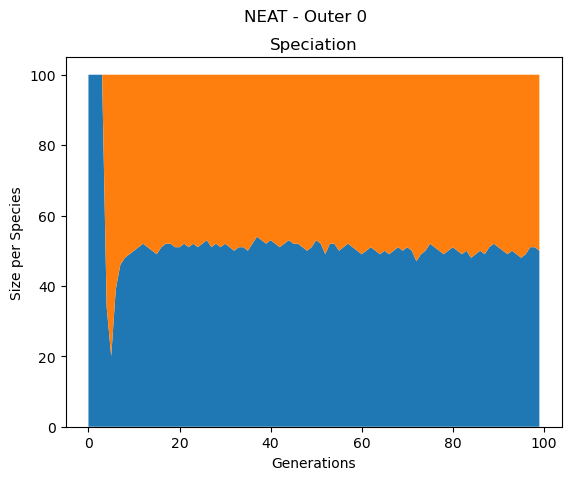

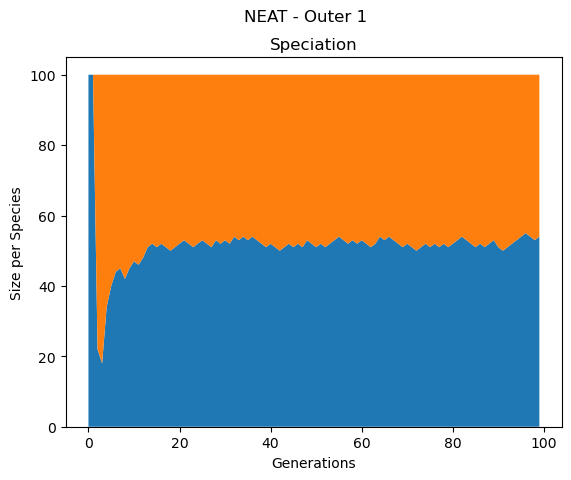

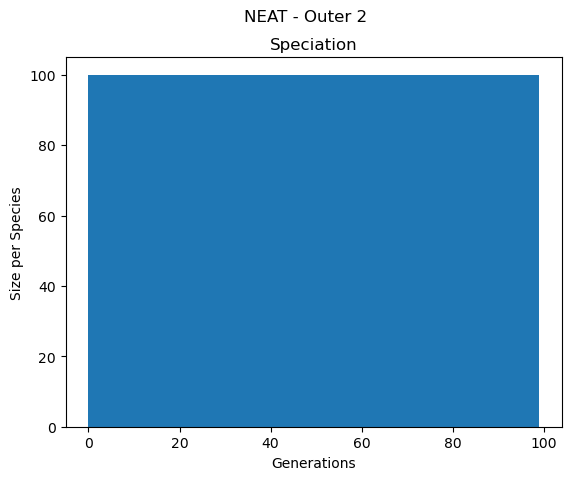

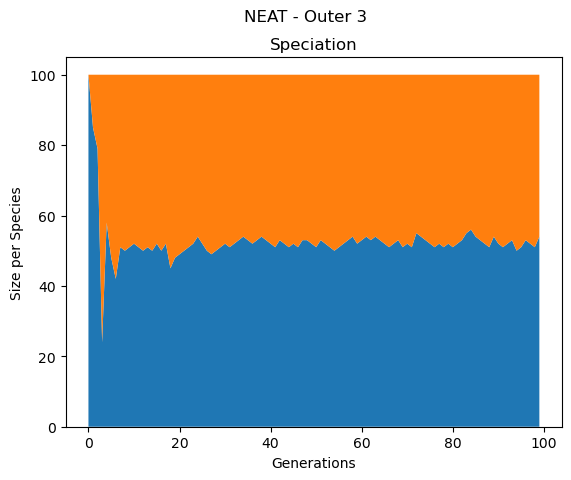

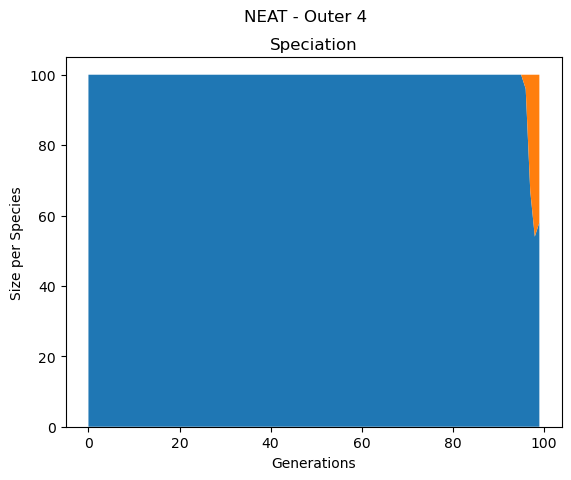

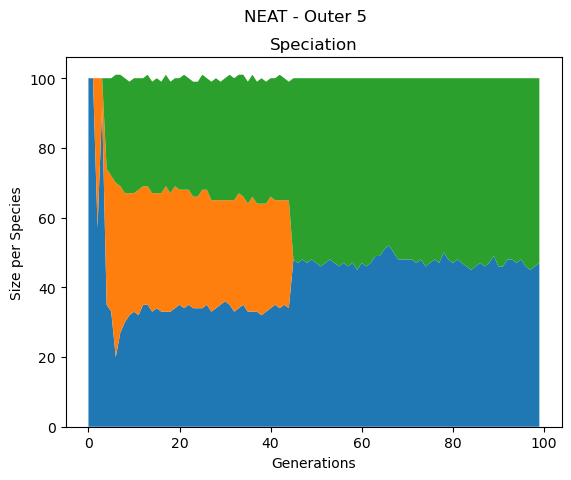

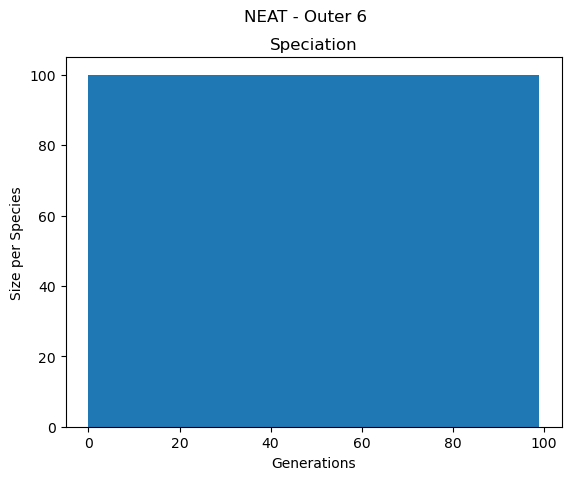

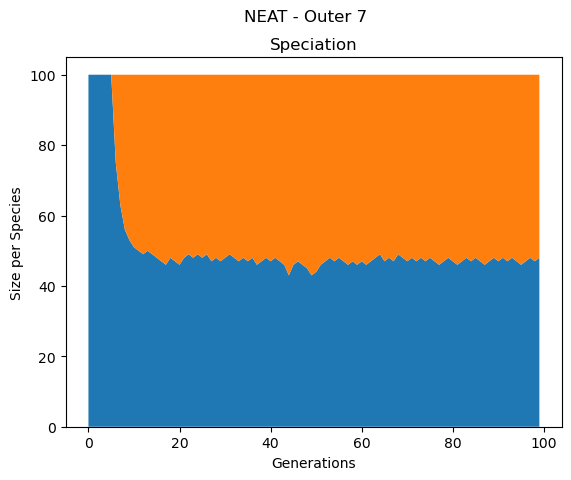

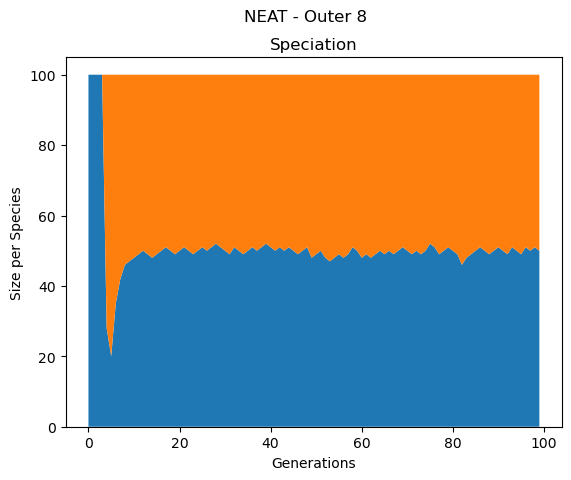

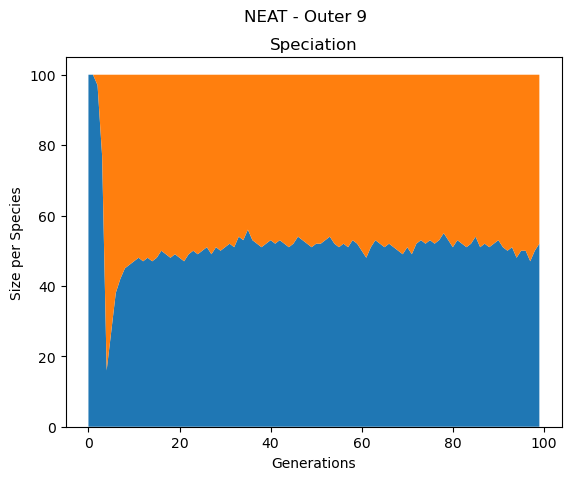

In [11]:
plot_species(k_outer=k_outer)

### Boxplot analysis

Even though we seached in a big space of hyperparameters (128 combinations) we concluded that no significant difference was found between the best and worst performing hyperparameters, as every outer loop landed on a unique combination. This suggests that the hyperparmeters we searched were not very sensitive to the performance of the model or the interval we used to evaluate the performance of the model was not enough to capture the differences in performance.

In [13]:
test_best_combs(model_name=MODEL_NAME)

- 

In [14]:
train_test_best_combs(model_name=MODEL_NAME)         

### Brief Discussion on Overfitting and Early Convergence

for the model's performance, we can asses that the number of generations we gave may be too much, as we notice that by the 70th generation, the model has already converged to a solution in most of the cases, althogh such a low number of species, as noticed before, may have influenced this result. Overfiting does not seem to be a problem, as the test result is not significantly different from the training result, which suggests that the model is not memorizing the training data but rather learning a generalizable solution.

In [ ]:
fit_or_size_per_comb(k_outer,MODEL_NAME, height=1800, width=1500, vertical_spacing=0.1, horizontal_spacing=0.1, title_y=.98,top_margin=200)

### Future Work

After running our training function (that contains the crossvalidation and the grid search) we realized that, when visualizing the speciation pattern, there was normally around 1 to 3 species identified. Therefore, in the future, it should be used a higher compatibility disjoint coefficient and compatibility weight coefficient, considering a higher distance between genomes, distributing even smaller differences into different groups. Consequently, it should lead to more species diversity seen in the plot, that should be used for later analysis. This will be changed and studied further for the final delivery. 
Additionally, we should also consider a different set of hyperparameters, as the ones we used did not show significant differences in performance, or at leas broader differences in the interval we used to evaluate the performance of the model.

# Second Attempt

In [20]:
seed = 42
random.seed(seed)

MODEL_NAME = 'NEAT_2'
DATASET_NAME = MODEL_NAME +'_sustavianfeed'
LOG_DIR = './log/' + MODEL_NAME + '/'

LOG_LEVEL = 2
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

In [21]:
k_outer = 10
k_inner = 5

In [22]:
# Turning df into X and y torch.Tensors
X, y = load_pandas_df(df, X_y=True)

In [23]:
fixed_params = {
    # Core NEAT population & evolution
    'pop_size':100, # Example: Try different population sizes
    
    # Essential for NEATWrapper initialization:
    'config_file_path': 'neat_config.txt', # Path to your NEAT config file
    'generations':100,                  # Number of generations for each NEAT run

    # Problem-specific parameters from NEAT config:
    'num_inputs': 12,
    'num_outputs': 1,
    'fitness_criterion': 'max',
    'fitness_threshold': 0.95,

    # Core NEAT algorithm parameters (usually fixed for a given experiment):
    'feed_forward': True,
    'activation_default': "relu",
    'activation_mutate_rate': 0.2, 
    'initial_connection': 'full_direct',
    'reset_on_extinction': False,
    'enabled_default': True,
    'enabled_mutate_rate': 0.01,
    'aggregation_default': 'sum',
    'aggregation_mutate_rate': 0.0,
    #'aggregation_options': 'sum', # Only 'sum' is an option here
    


    # Bias mutation parameters (often fixed, but 'bias_mutate_rate' can be dynamic)
    'bias_init_mean': 0.0,
    'bias_init_stdev': 1.0,
    'bias_max_value': 30.0,
    'bias_min_value': -30.0,
    'bias_mutate_power': 0.5,
    'bias_replace_rate': 0.1,
    'bias_mutate_rate': 0.6, 

    # Node response parameters (often fixed, but 'response_mutate_rate' can be dynamic)
    'response_init_mean': 0.0,
    'response_init_stdev': 1.0,
    'response_max_value': 30.0,
    'response_min_value': -30.0,
    'response_mutate_power': 1.0,
    'response_replace_rate': 0.0,
    'response_mutate_rate': 0.6, # Example: Probability of mutating node response (gain)

    # Weight mutation parameters (often fixed, but 'weight_mutate_rate' can be dynamic)
    'weight_init_mean': 0.0,
    'weight_init_stdev': 1.0,
    'weight_max_value': 30,
    'weight_min_value': -30,
    'weight_mutate_power': 0.5,
    'weight_replace_rate': 0.1,

    # Speciation and Reproduction parameters:
    'species_fitness_func': 'max',
    'max_stagnation': 20,
    'species_elitism': 2,
    'elitism': 2,
    'survival_threshold': 0.2,
    'compatibility_disjoint_coefficient': 0.9,
    'compatibility_weight_coefficient': 0.8,

    # Placeholder for data and log_level (set dynamically by nested CV function):
    'X_train': None,
    'y_train': None,
    'X_test': None,
    'y_test': None,
    'log_level': 0 # NEAT logging verbosity (0 for inner, 2 for outer)
}


param_grid = {
    # Connection parameters
    'conn_add_prob': [0.5,0.6],  # Example: Probability of adding a new connection
    'conn_delete_prob': [0.1,0.2], # Example: Probability of deleting a connection
    'weight_mutate_rate': [0.7,0.8], # Example: Probability of mutating connection weights

    # Node addition/deletion (controls topology evolution)
    'node_add_prob': [0.05, 0.1], # Example: Probability of adding a new node (often small)
    'node_delete_prob': [0.01, 0.05], # Example: Probability of deleting a node (even smaller)

    
}

In [ ]:
# the output files of this line have already bee saved in the log directory
outer_results = gp_nested_cross_validation(X, y, gp_model=NEATWrapper, k_outer=k_outer, k_inner=k_inner, fixed_params=fixed_params, param_grid=param_grid, seed=seed, LOG_DIR=LOG_DIR, DATASET_NAME=DATASET_NAME)

Saving results and configs to a .csv 

In [ ]:
outer_results_df = pd.DataFrame(outer_results)
outer_results_df.to_csv(LOG_DIR+DATASET_NAME+'_outer_results.csv', index=False)

## Visualizations 

### Speciation graphs
With increased compatibility_disjoint_coefficient and compatibility_weight_coefficient, we get much more species, as expected and stated above. Additionally, it can be seen some species being extinguished throughout the generations in every outers. We consider this to be the normal flow of the genome evolutions.

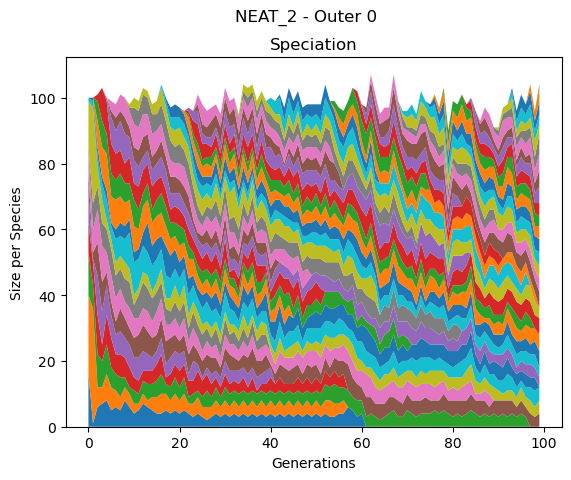

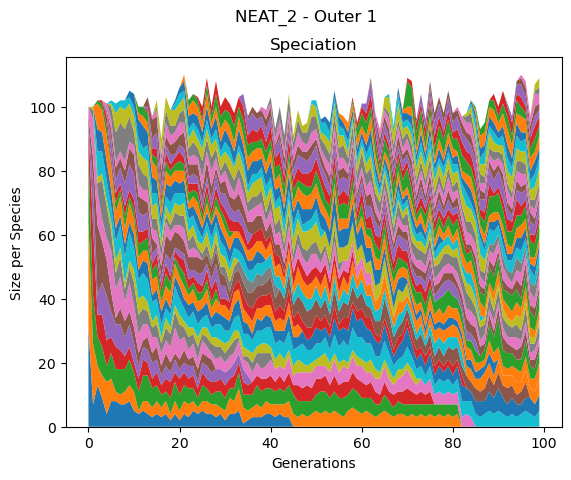

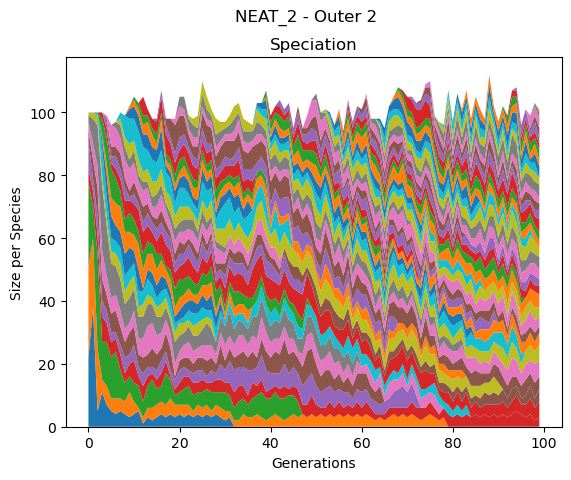

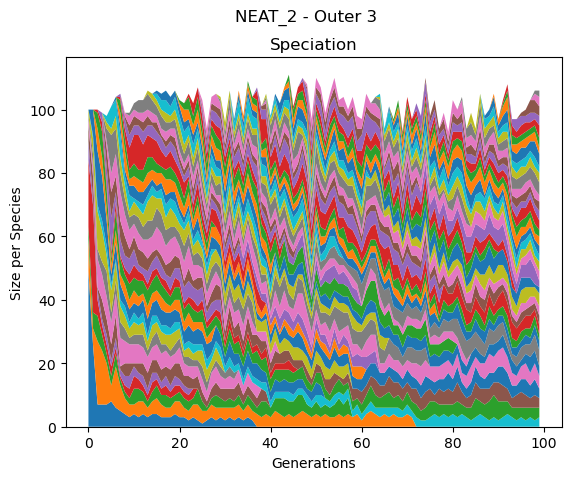

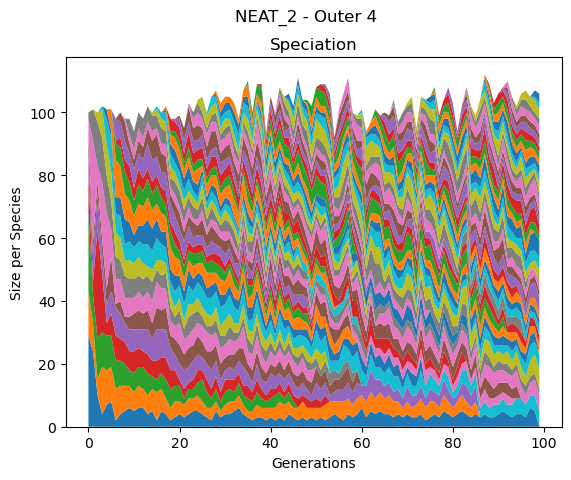

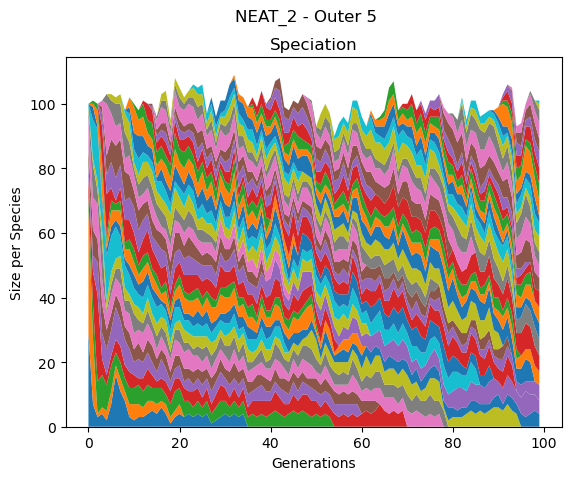

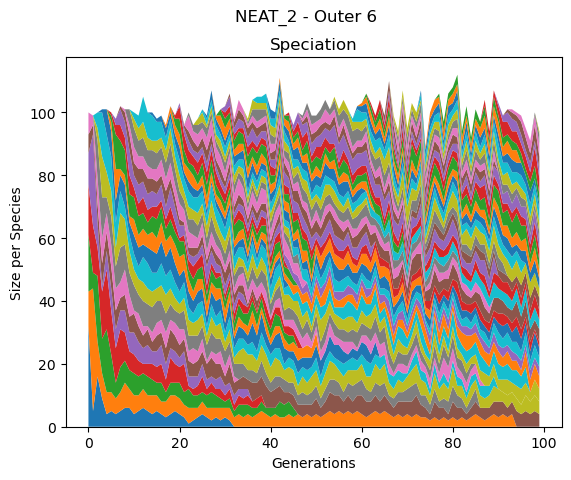

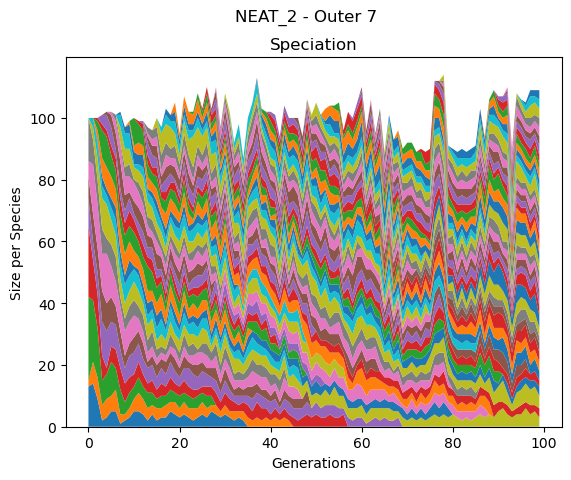

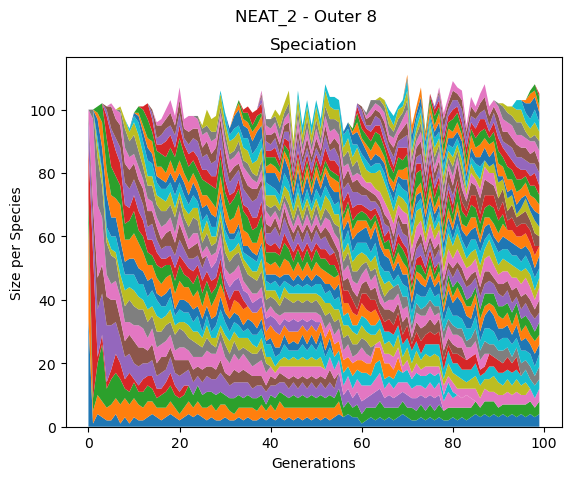

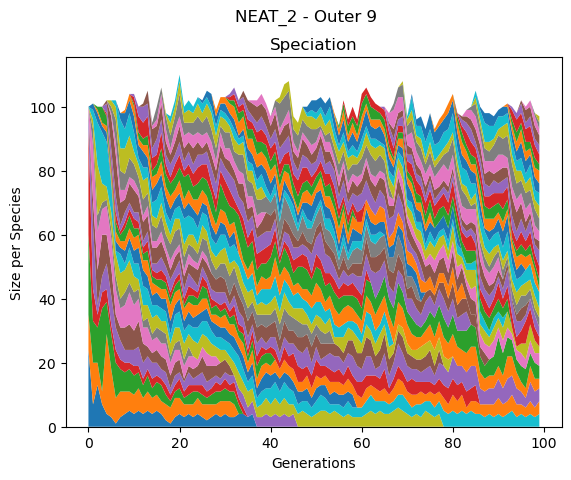

In [24]:
plot_species(k_outer=k_outer, model_name=MODEL_NAME)

### Boxplot analysis

- Firstly, we can already see that the fitness results are worse in comparison to the first approach (the one with fewer species). Given these results and that our population is only of size 100, we consider that there are too much species now, i.e. too much diversity. These worse results can be due to the fitness sharing occuring in a much smaller niche of individuals.

- Only two outer loops were trained with the same combination. This suggests that the hyperparmeters we searched were not very sensitive to the performance of the model or the number of outer loops was not enough to capture the differences in performance.

In [25]:
test_best_combs(model_name=MODEL_NAME)

- 

In [26]:
train_test_best_combs(model_name=MODEL_NAME)         

### Brief Discussion on Overfitting and Early Convergence

- In this approach, we can see there is a later convergence than before. Nonetheless, it seems to converge overall.

- Once again, neither overfiting or underfiiting do not seem to be a problem, as the test result is not significantly different from the training result, suggesting a good generalibility towards unseen data.

In [27]:
fit_or_size_per_comb(k_outer,MODEL_NAME, height=1800, width=1500, vertical_spacing=0.1, horizontal_spacing=0.1, title_y=.98,top_margin=200)